In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import pickle5 as pickle
import pandas as pd
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
import colorcet as cc

# Plotting functions

In [2]:
def plot_field(ax, field, cmap, plot_type='pcolormesh', lon_bounds=None, lat_bounds=None, 
               levels=21, vmin=None, vmax=None, title=None, cbar_label=None, only_ROI=False):
    #### FIX: Comment function
    
    # Select map features
    oceans_50m = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m')
    lakes_50m = cartopy.feature.NaturalEarthFeature('physical', 'lakes', '50m')
    states_provinces_50m = cartopy.feature.NaturalEarthFeature('cultural','admin_1_states_provinces_lines', '50m')
    ax.add_feature(cartopy.feature.BORDERS, facecolor='none')
    ax.add_feature(oceans_50m, facecolor=[0.9,0.975,1], edgecolor='black')
    ax.add_feature(lakes_50m, facecolor=[0.9,0.975,1], edgecolor='black')
    ax.add_feature(states_provinces_50m, facecolor='none', edgecolor='black')
    
    # Show only ROI values?
    if only_ROI:
        field = field.where((state_vector_labels <= last_ROI_cluster))  
        #### FIX? Requires pre-defined state_vector_labels and last_ROI_cluster
    
    # Plot
    if plot_type == 'pcolormesh':
        field.plot.pcolormesh(cmap=cmap, levels=levels, ax=ax,
                              vmin=vmin, vmax=vmax, cbar_kwargs={'label':cbar_label,
                                                                 'fraction':0.041, 
                                                                 'pad':0.04})
    elif plot_type == 'imshow':
        field.plot.imshow(cmap=cmap, ax=ax,
                          vmin=vmin, vmax=vmax, cbar_kwargs={'label':cbar_label,
                                                             'fraction':0.041, 
                                                             'pad':0.04})
    else:
        raise ValueError('plot_type must be "pcolormesh" or "imshow"')
    
    # Zoom on ROI?
    if lon_bounds and lat_bounds:
        extent = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
    # Remove duplicated axis labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0)
    gl.ylabels_right = False
    gl.xlabels_top = False
    
    # Title
    if title:
        ax.set_title(title);

def load_obj(name):
    """ Load something with Pickle. """
    with open( name, 'rb') as f:
        return pickle.load(f)

# State vector

In [3]:
# Load state vector file
state_vector_filepath = './../Clusters_permian_kmeans.nc'             #### FIX: Hard-coded, Permian filepath
state_vector = xr.open_dataset(state_vector_filepath)

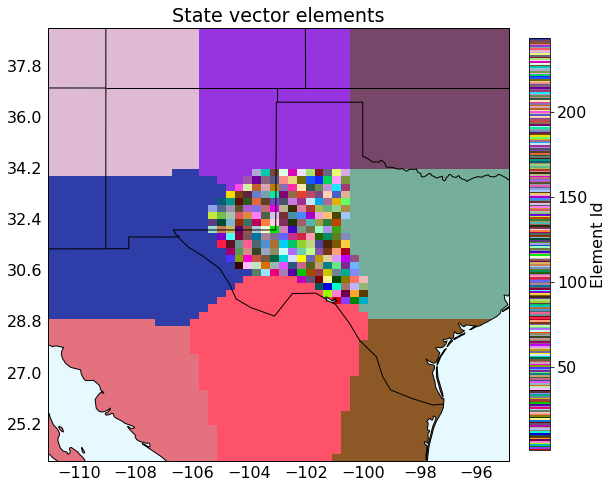

In [4]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

state_vector_labels = state_vector['Clusters']          #### FIX: Remove "clusters" language

plot_field(ax, state_vector_labels, plot_type='imshow', cmap=cc.cm.glasbey, 
           title='State vector elements', cbar_label='Element Id')

# Inversion results

In [5]:
# Paths to prior emissions, inversion results, GEOS/satellite data, posterior simulation
prior_pth = './../demonstration_data/edf_prior/HEMCO_diagnostics.201805010000.nc'   #### FIX
scale_pth = './../demonstration_data/edf_prior/gridded_posterior.nc'                #### FIX
satdat_dir = './../demonstration_data/edf_prior/inversion_output'                   #### FIX
inversion_result_path = './../demonstration_data/edf_prior/inversion_result.nc'     #### FIX
posterior_dir = './../demonstration_data/edf_posterior/sampling_output'

In [6]:
# Set latitude/longitude bounds
mean_lon = np.mean(state_vector.lon.values)
mean_lat = np.mean(state_vector.lat.values)
window_radius = 5 # degrees
lon_bounds = [mean_lon-window_radius, mean_lon+window_radius]
lat_bounds = [mean_lat-window_radius, mean_lat+window_radius]

### Prior and Posterior emissions

In [7]:
def sum_total_emissions(emissions, areas, clusters, last_ROI_cluster):
    #### FIX: Remove "clusters" language
    #### FIX: Comment function
    s_per_d = 86400
    d_per_y = 365
    tg_per_kg = 1e-9
    xgrid = range(len(clusters.lon.values))
    ygrid = range(len(clusters.lat.values))    
    permian_mask = (clusters <= last_ROI_cluster)
    emiss = []
    for j in xgrid:
        for i in ygrid:
            if permian_mask.values[i,j] == 1:
                emiss.append(emissions.values[i,j])
    total = np.sum(np.asarray([areas[r] * emiss[r] for r in range(len(areas))]))
    return total * s_per_d * d_per_y * tg_per_kg

In [8]:
# Load prior emissions and optimized scale factors
# Then compute posterior emissions
prior = xr.open_dataset(prior_pth)['EmisCH4_Total'].isel(time=0)
scale = xr.open_dataset(scale_pth)['SF_Nonwetland']                 #### FIX: Remove "Nonwetland" language
posterior = prior * scale

In [9]:
# Compute total emissions
areas = np.load('./../areas.npy')                                   #### FIX: Need to provide code to create areas.py
last_ROI_cluster = 235                                              #### FIX: Remove "clusters" language, hardcode 235

print('Prior     emissions :', sum_total_emissions(prior, areas, state_vector_labels, last_ROI_cluster), 'Tg/y')
print('Posterior emissions :', sum_total_emissions(posterior, areas, state_vector_labels, last_ROI_cluster), 'Tg/y')

Prior     emissions : 2.738888671408107 Tg/y
Posterior emissions : 3.527493489349291 Tg/y


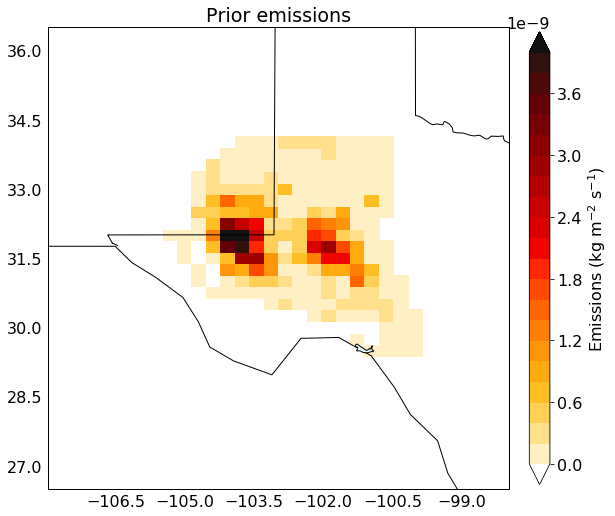

In [10]:
# Plot prior emissions
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, prior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Prior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True)

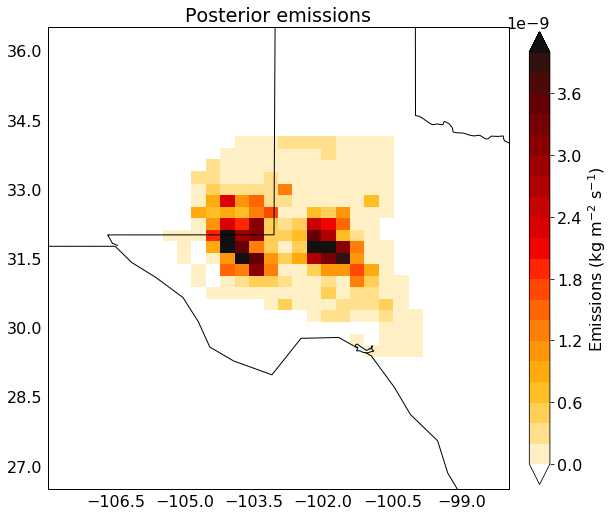

In [11]:
# Plot posterior emissions
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, posterior, cmap=cc.cm.linear_kryw_5_100_c67_r, 
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=4e-9, title='Posterior emissions', cbar_label='Emissions (kg m$^{-2}$ s$^{-1}$)',
           only_ROI=True)

### Scale factors

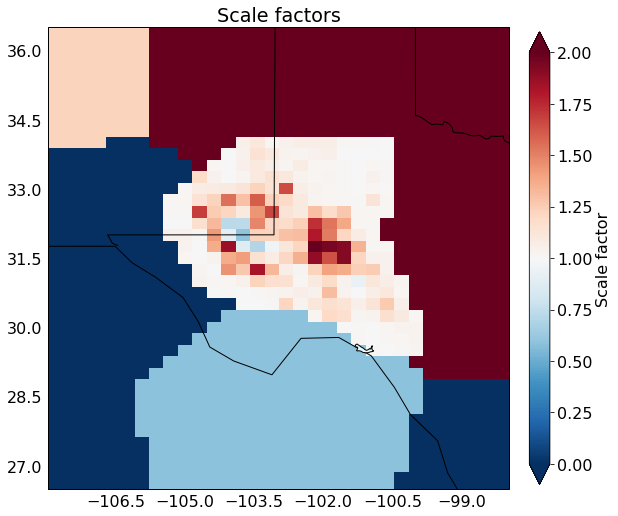

In [12]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, scale, cmap='RdBu_r', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           vmin=0, vmax=2, title='Scale factors', cbar_label='Scale factor',
           only_ROI=False)

### Averaging kernel sensitivities

In [13]:
import sys
sys.path.append("../")
from step3_error_avk import calc_Spost_A                                 #### FIX: now rolled into inversion_results
from make_gridded_averaging_kernel import make_gridded_averaging_kernel  #### FIX: now rolled into inversion_results

In [14]:
S_hat, A = calc_Spost_A(inversion_result_path)
A_diag = np.diag(A).copy()
A_grid = make_gridded_averaging_kernel(A_diag,state_vector_filepath)
A_grid['Averaging_kernel'] = A_grid['Averaging_kernel'].where(state_vector_labels <= last_ROI_cluster)
avkern = A_grid['Averaging_kernel']

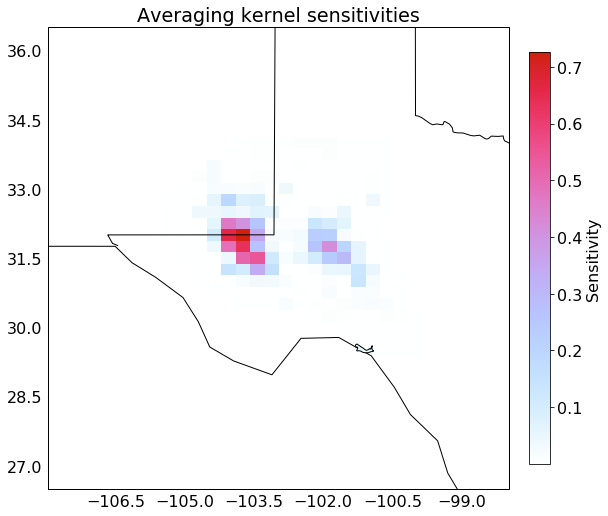

In [15]:
fig = plt.figure(figsize=(9,9))
plt.rcParams.update({'font.size': 16})
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, avkern, cmap=cc.cm.CET_L19, plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Averaging kernel sensitivities', cbar_label='Sensitivity', 
           only_ROI=True)

#avkern.plot.imshow(cmap=cc.cm.CET_L19, cbar_kwargs={'label':'Sensitivity',
#                                                 'fraction':0.037, 
#                                                 'pad':0.04})

In [16]:
DOFS = np.sum(A_diag[:last_ROI_cluster])
print('DOFS =', DOFS)

DOFS = 10.847433316047644


# Compare TROPOMI and GEOS-Chem columns

In [17]:
# Redefine lat/lon bounds
lat_bounds = [30,34.5]
lon_bounds = [-106,-100]

In [18]:
# Get observed and GEOS-Chem-simulated TROPOMI columns
files = np.sort(os.listdir(satdat_dir))
lat = np.array([])
lon = np.array([])
tropomi = np.array([])
geos_prior = np.array([])
geos_posterior = np.array([])

for f in files:
    # Get paths
    pth = os.path.join(satdat_dir,f)
    pth_posterior = os.path.join(posterior_dir,f)
    # Load TROPOMI/GEOS-Chem and Jacobian matrix data from the .pkl file
    obj = load_obj(pth)
    obj_posterior = load_obj(pth_posterior)
    # If there aren't any TROPOMI observations on this day, skip
    if obj['obs_GC'].shape[0] == 0:
        continue
    # Otherwise, grab the TROPOMI/GEOS-Chem data
    obs_GC = obj['obs_GC']
    obs_GC_posterior = obj_posterior['obs_GC']
    # Only consider data within latitude and longitude bounds
    ind = np.where((obs_GC[:,2]>=lon_bounds[0]) & (obs_GC[:,2]<=lon_bounds[1]) & 
                   (obs_GC[:,3]>=lat_bounds[0]) & (obs_GC[:,3]<=lat_bounds[1]))
    if (len(ind[0]) == 0):          # Skip if no data in bounds
        continue
    obs_GC = obs_GC[ind[0],:]       # TROPOMI and GEOS-Chem data within bounds
    obs_GC_posterior = obs_GC_posterior[ind[0],:]
    # Record lat, lon, tropomi ch4, and geos ch4
    lat = np.concatenate((lat, obs_GC[:,3]))
    lon = np.concatenate((lon, obs_GC[:,2]))
    tropomi = np.concatenate((tropomi, obs_GC[:,0]))
    geos_prior = np.concatenate((geos_prior, obs_GC[:,1]))
    geos_posterior = np.concatenate((geos_posterior, obs_GC_posterior[:,1]))
    
df = pd.DataFrame()
df['lat'] = lat
df['lon'] = lon
df['tropomi'] = tropomi
df['geos_prior'] = geos_prior
df['geos_posterior'] = geos_posterior
df['diff_tropomi_prior'] = geos_prior - tropomi
df['diff_tropomi_posterior'] = geos_posterior - tropomi
n_obs = len(tropomi)

print('Found',n_obs,'TROPOMI observations')
df.head()

Found 26691 TROPOMI observations


,lat,lon,tropomi,geos_prior,geos_posterior,diff_tropomi_prior,diff_tropomi_posterior
0,30.038645,-101.900795,1820.077026,1834.875977,1835.163086,14.798950,15.086060
1,30.038513,-101.705368,1826.551880,1836.817261,1837.352539,10.265381,10.800659
2,30.037859,-101.504204,1819.048706,1838.319214,1839.062256,19.270508,20.013550
3,30.101398,-101.716606,1828.823242,1836.411133,1836.926758,7.587891,8.103516
4,30.100719,-101.515320,1824.439087,1838.272095,1839.041260,13.833008,14.602173


In [19]:
# Print some error statistics
print('Bias in prior     :'  , np.round(df['diff_tropomi_prior'].mean(),2),'ppb')
print('Bias in Posterior :' , np.round(df['diff_tropomi_posterior'].mean(),2),'ppb')
print('RMSE prior        :'  , np.round(np.sqrt(np.mean(df['diff_tropomi_prior']**2)),2),'ppb')
print('RMSE posterior    :'  , np.round(np.sqrt(np.mean(df['diff_tropomi_posterior']**2)),2),'ppb')

Bias in prior     : -1.63 ppb
Bias in Posterior : -0.95 ppb
RMSE prior        : 12.67 ppb
RMSE posterior    : 11.89 ppb


### Compare at 0.1 x 0.1 resolution

In [20]:
# Simple averaging scheme to grid the XCH4 data at 0.1 x 0.1 resolution
df['lat'] = np.round(df['lat'],1)
df['lon'] = np.round(df['lon'],1)
df = df.groupby(['lat','lon']).mean()
ds = df.to_xarray()
ds

<xarray.Dataset>
Dimensions:                 (lat: 46, lon: 61)
Coordinates:
  * lat                     (lat) float64 30.0 30.1 30.2 30.3 ... 34.3 34.4 34.5
  * lon                     (lon) float64 -106.0 -105.9 -105.8 ... -100.1 -100.0
Data variables:
    tropomi                 (lat, lon) float64 1.825e+03 1.826e+03 ... 1.835e+03
    geos_prior              (lat, lon) float64 1.829e+03 1.828e+03 ... 1.835e+03
    geos_posterior          (lat, lon) float64 1.827e+03 1.827e+03 ... 1.838e+03
    diff_tropomi_prior      (lat, lon) float64 3.271 2.105 ... 1.465 -0.4143
    diff_tropomi_posterior  (lat, lon) float64 1.749 1.408 3.611 ... 5.338 2.232

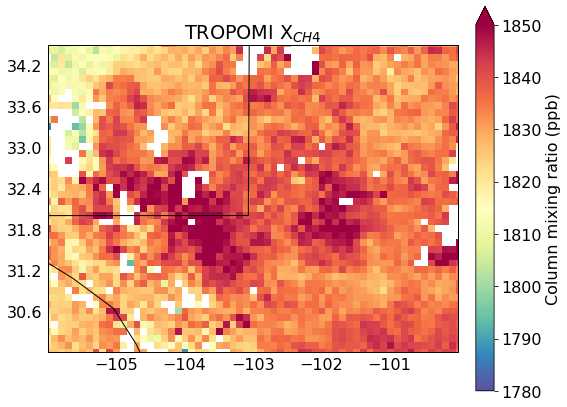

In [21]:
# Mean TROPOMI XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds['tropomi'], cmap='Spectral_r', plot_type='imshow',
           vmin=1780, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='TROPOMI X$_{CH4}$', cbar_label='Column mixing ratio (ppb)', 
           only_ROI=False)

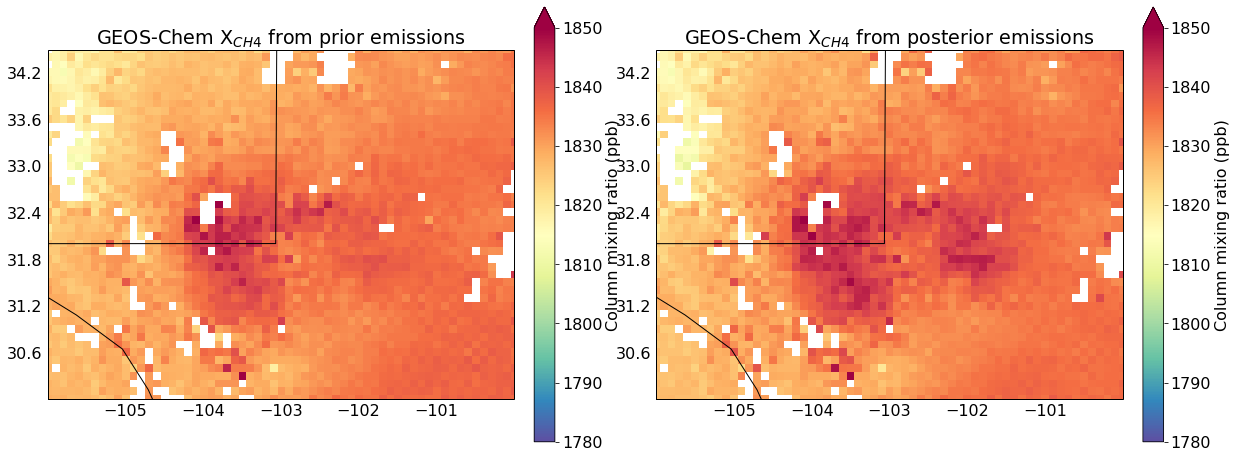

In [22]:
# Mean prior and posterior GEOS-Chem XCH4 columns on 0.1 x 0.1 grid
fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds['geos_prior'], cmap='Spectral_r', plot_type='imshow',
           vmin=1780, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='GEOS-Chem X$_{CH4}$ from prior emissions', cbar_label='Column mixing ratio (ppb)', 
           only_ROI=False)

plot_field(ax2, ds['geos_posterior'], cmap='Spectral_r', plot_type='imshow',
           vmin=1780, vmax=1850, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='GEOS-Chem X$_{CH4}$ from posterior emissions', cbar_label='Column mixing ratio (ppb)', 
           only_ROI=False)

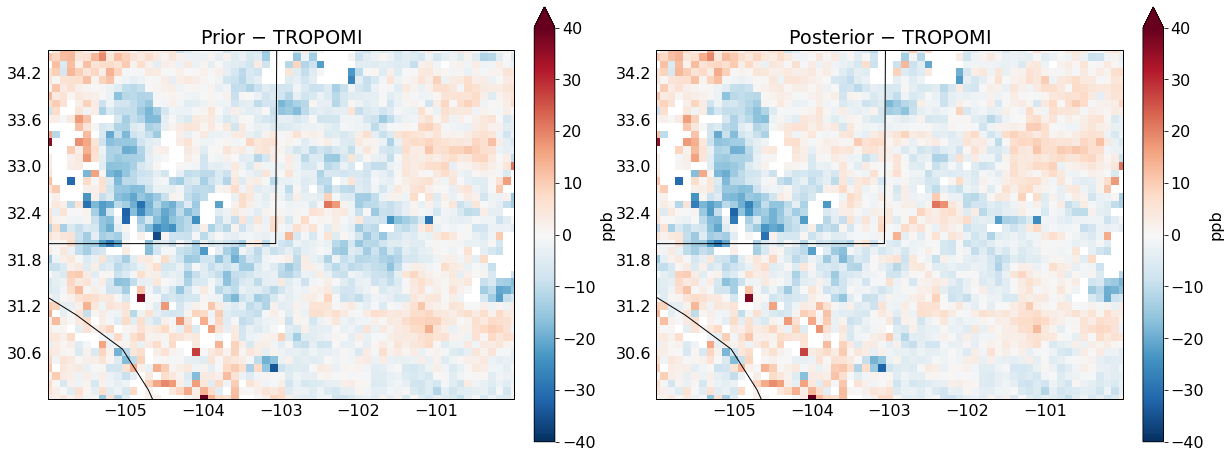

In [23]:
# Plot differences between GEOS-Chem and TROPOMI XCH4
fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds['diff_tropomi_prior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-40, vmax=40, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Prior $-$ TROPOMI', cbar_label='ppb', 
           only_ROI=False)

plot_field(ax2, ds['diff_tropomi_posterior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-40, vmax=40, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ TROPOMI', cbar_label='ppb', 
           only_ROI=False)

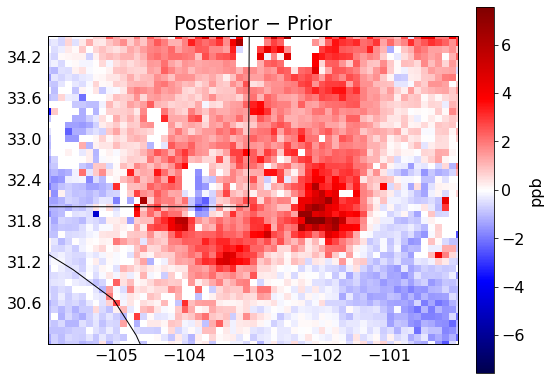

In [24]:
# Plot differences between posterior and prior simulated XCH4
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds['geos_posterior']-ds['geos_prior'], 
           cmap='seismic', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ Prior', cbar_label='ppb', 
           only_ROI=False)

### Compare at 0.25 x 0.3125 resolution

In [25]:
# Global 0.25 x 0.3125 grid
reference_lat_grid = np.arange(-90 , 90+0.25   , 0.25)
reference_lon_grid = np.arange(-180, 180+0.3125, 0.3125)

# Find closest reference coordinates to selected lat/lon bounds
lat_min = reference_lat_grid[np.abs(reference_lat_grid - lat_bounds[0]).argmin()]
lon_min = reference_lon_grid[np.abs(reference_lon_grid - lon_bounds[0]).argmin()]
lat_max = reference_lat_grid[np.abs(reference_lat_grid - lat_bounds[1]).argmin()]
lon_max = reference_lon_grid[np.abs(reference_lon_grid - lon_bounds[1]).argmin()]

# Create an xESMF regridder object to resample the mask on the grid HEMCO expects
new_lat_grid = np.arange(lat_min, lat_max+0.25, 0.25)
new_lon_grid = np.arange(lon_min, lon_max+0.3125, 0.3125)
ds_out = xr.Dataset({'lat': (['lat'], new_lat_grid),
                     'lon': (['lon'], new_lon_grid),
                    }
                   )

regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_46x61_19x20.nc 
Reuse pre-computed weights? False 
Input grid shape:           (46, 61) 
Output grid shape:          (19, 20) 
Periodic in longitude?      False

In [26]:
# Regrid the data
ds_regrid = regridder(ds)
ds_regrid

<xarray.Dataset>
Dimensions:                 (lat: 19, lon: 20)
Coordinates:
  * lon                     (lon) float64 -105.9 -105.6 -105.3 ... -100.3 -100.0
  * lat                     (lat) float64 30.0 30.25 30.5 ... 34.0 34.25 34.5
Data variables:
    tropomi                 (lat, lon) float64 0.0 0.0 ... 1.836e+03 1.835e+03
    geos_prior              (lat, lon) float64 0.0 0.0 ... 1.833e+03 1.835e+03
    geos_posterior          (lat, lon) float64 0.0 0.0 ... 1.835e+03 1.838e+03
    diff_tropomi_prior      (lat, lon) float64 0.0 0.0 0.0 ... -2.7 -0.4143
    diff_tropomi_posterior  (lat, lon) float64 0.0 0.0 0.0 ... -0.3075 2.232
Attributes:
    regrid_method:  bilinear

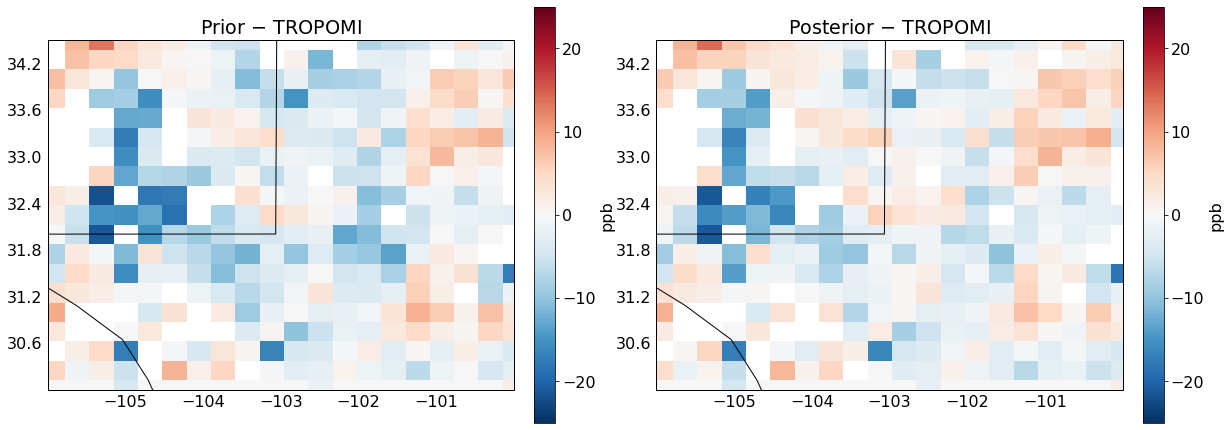

In [27]:
# Re-plot differences between GEOS-Chem and TROPOMI XCH4
fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax1, ds_regrid['diff_tropomi_prior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-25, vmax=25, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Prior $-$ TROPOMI', cbar_label='ppb', 
           only_ROI=False)

plot_field(ax2, ds_regrid['diff_tropomi_posterior'], cmap='RdBu_r', plot_type='imshow',
           vmin=-25, vmax=25, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ TROPOMI', cbar_label='ppb', 
           only_ROI=False)

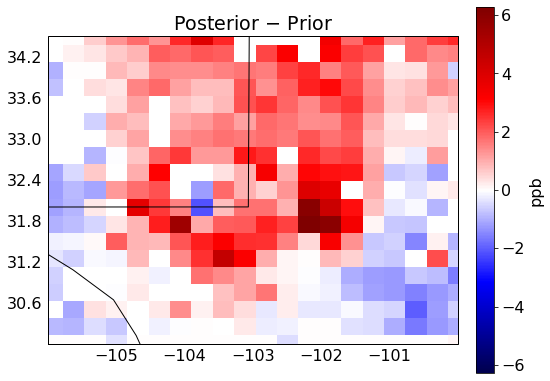

In [28]:
# Re-plot differences between posterior and prior simulated XCH4
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1,subplot_kw={'projection': ccrs.PlateCarree()})

plot_field(ax, ds_regrid['geos_posterior']-ds_regrid['geos_prior'], 
           cmap='seismic', plot_type='imshow',
           lon_bounds=lon_bounds, lat_bounds=lat_bounds,
           title='Posterior $-$ Prior', cbar_label='ppb', 
           only_ROI=False)

----